In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

print(torch.cuda.is_available())

True


[d3-w4140b-04:2004597] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.d3-w4140b-04.614072/jf.0/2560294912/shared_mem_cuda_pool.d3-w4140b-04 could be created.
[d3-w4140b-04:2004597] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


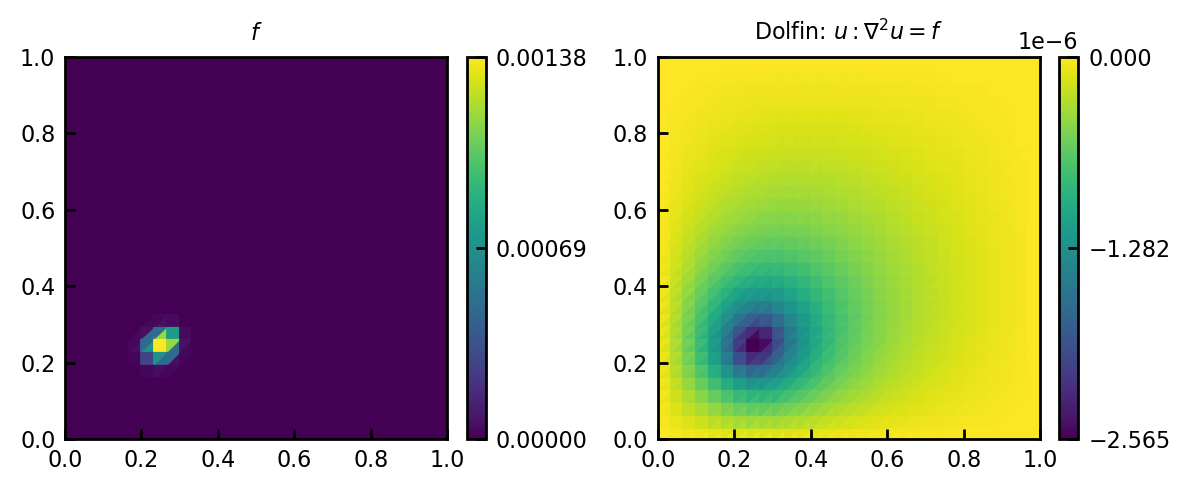

In [2]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import *

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

inputs[2] = 0.
inputs[2, 25, 25] = 1.

from scipy.ndimage import gaussian_filter
def forcing_function(xyc):
    """ Convolution of poit sources with gaussian """
    force = gaussian_filter(xyc[2], sigma=2) * np.sin(xyc[0]) * np.sin(xyc[1])
    return force

mesh_size = 30
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildPoissonProblem(mesh)

F = forcing_function(inputs)
force = scalar_img_to_mesh(F, X.flatten(), Y.flatten(), build_problem.function_space, use_torch=False, vals_only=False)
dlf_sol = build_problem.forward(force)

# Plot and compare
fig, ax = plt.subplots(1, 2, figsize=(6,2.5))
ax = ax.flatten()

# Forcing function
plot_mesh(force.compute_vertex_values(), mesh, ax[0])
ax[0].set_title(r'$f$')

# Dolfin solutios
plot_mesh(dlf_sol.compute_vertex_values(), mesh, ax[1])
ax[1].set_title(r'Dolfin: $u: \nabla^2 u = f$')

plt.tight_layout()

In [3]:
import h5py
from tqdm import trange

dataset_size = 512
mesh_size = 30
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildPoissonProblem(mesh)

F = forcing_function(inputs)
force = scalar_img_to_mesh(F, X.flatten(), Y.flatten(), build_problem.function_space, use_torch=False, vals_only=False)

dlf_sol = build_problem.forward(force)


X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

with h5py.File('poisson_dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.create_dataset('mesh_size', data=mesh_size)
    h5f.create_dataset('dataset_size', data=dataset_size)

    h5f.create_dataset('inputs', shape=[dataset_size, *inputs.shape], dtype=np.float32)
    h5f.create_dataset('forces', shape=[dataset_size, 1, *inputs.shape[1:]], dtype=np.float32)
    h5f.create_dataset('outputs', shape=[dataset_size, mesh.coordinates().shape[0]])

    for i in trange(dataset_size):
        inputs[2] = 0.
        for j in range(5):
            inputs[2, np.random.randint(25, 75), np.random.randint(25, 75)] += 1.

        force = forcing_function(inputs)
        force_mesh = scalar_img_to_mesh(
            force, 
            X.flatten(), 
            Y.flatten(), 
            build_problem.function_space, 
            use_torch=False, vals_only=False)
        
        output = build_problem.forward(force_mesh).compute_vertex_values()

        h5f['inputs'][i] = inputs
        h5f['forces'][i] = force
        h5f['outputs'][i] = output



Opened file for writing


100%|██████████| 512/512 [00:10<00:00, 49.69it/s]


30


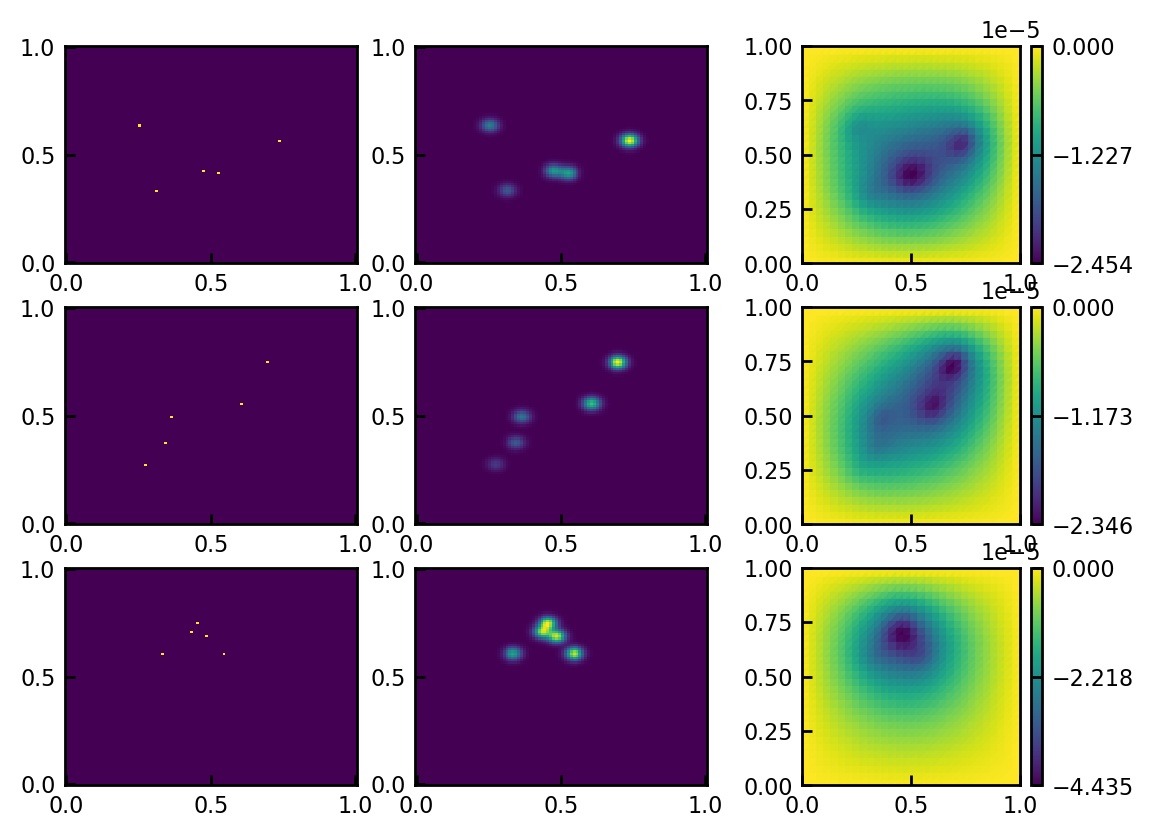

In [4]:
fig, ax = plt.subplots(3, 3)

with h5py.File('poisson_dataset.hdf5', 'r') as h5f:
    print(h5f['mesh_size'][()])
    mesh = d_ad.UnitSquareMesh(nx=h5f['mesh_size'][()], ny=h5f['mesh_size'][()])

    for i in range(3):
        inputs = h5f['inputs'][i]
        ax[i, 0].pcolormesh(inputs[0], inputs[1], inputs[2])
        ax[i, 1].pcolormesh(inputs[0], inputs[1], h5f['forces'][i, 0])
        plot_mesh(h5f['outputs'][i], mesh, ax[i, 2])